In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [6]:
bright_factor = 0
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 0, "config.use_testset": True}, order="-summary_metrics.test_acc")

runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 1,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True}, order="-summary_metrics.test_acc")

In [7]:
print(len(runs_dict["runs_homeostasis"]))

120


30


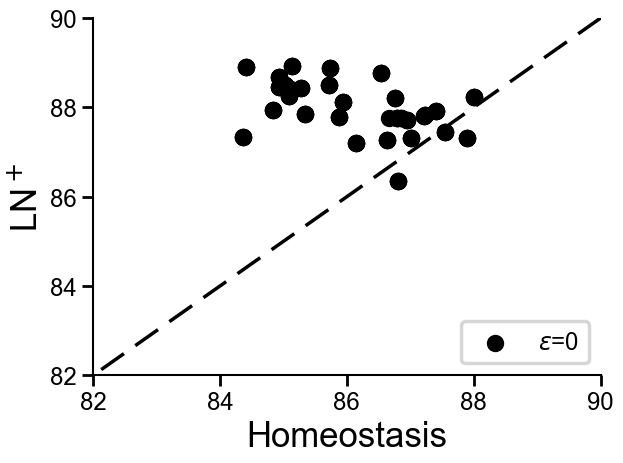

In [8]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

list_line = range(100)

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann_layernorm"][top].summary['test_acc']
    for rn in runs_dict["runs_homeostasis"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann_layernorm"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", label=f"$\epsilon$={bright_factor}" if label_flag else None)
            label_flag = False


print(len(runs_dict["runs_vanilla_dann_layernorm"]))
#ax.set_xlabel(f"LN$^+$")
ax.set_xlabel("Homeostasis", fontsize=25)
ax.set_ylabel("LN$^+$", fontsize=25)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
list_line = range(100)
ax.set_xlim(82, 90)
ax.set_ylim(82, 90)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.legend(loc='lower right')
# Set larger font sizes for the tick numbers
plt.show()


/tmp/ipykernel_4041423/2062939348.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp1 = ax1.boxplot(np.array(mu_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
/tmp/ipykernel_4041423/2062939348.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp2 = ax2.boxplot(np.array(var_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),


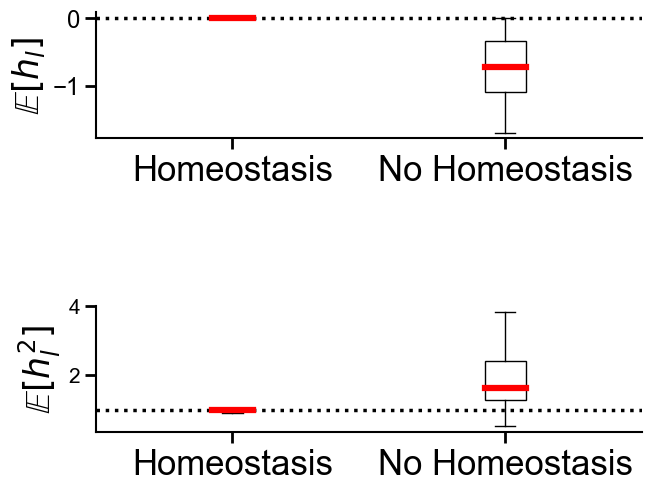

In [7]:
fig = plt.figure(layout="constrained")

plt.rcParams['figure.constrained_layout.use'] = False


gs1 = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mu_dann = []

mu_dann.append([run_van.summary['train_fc1_mu'] for run_van in runs_dict["runs_homeostasis"]])

mu_dann.append([run_van.summary['train_fc1_mu'] for run_van in runs_dict["runs_vanilla_dann"]])

var_dann = []

var_dann.append([run_van.summary['train_fc1_var'] for run_van in runs_dict["runs_homeostasis"]])

var_dann.append([run_van.summary['train_fc1_var'] for run_van in runs_dict["runs_vanilla_dann"]])


bp1 = ax1.boxplot(np.array(mu_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

median_colors = ["red", 'red']

# Iterate over each median line and set its color
for median, color in zip(bp1['medians'], median_colors):
    median.set_color(color)
    median.set_linewidth(4.5)  # Set thickness

bp2 = ax2.boxplot(np.array(var_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

median_colors = ["red", 'red']

# Iterate over each median line and set its color
for median, color in zip(bp2['medians'], median_colors):
    median.set_color(color)
    median.set_linewidth(4.5)  # Set thickness

# Create custom x-axis tick labels
custom_xticks = ["Homeostasis", "No Homeostasis"]
ax1.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax1.set_xticklabels(custom_xticks, fontsize=25)
ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax2.set_xticklabels(custom_xticks, fontsize=25)
ax2.axhline(y=1, color='black', linestyle='dotted')

ax1.set_ylabel('First Moment', fontsize=20)
ax1.set_ylabel('$\mathbb{E}[h_l]$', fontsize=25)
ax2.set_ylabel('Second Moment', fontsize=20)
ax2.set_ylabel('$\mathbb{E}[h^2_l]$', fontsize=25)
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
# ax2.set_yscale('log')

# Set larger font sizes for the tick numbers
plt.yticks(fontsize=15)
# ax1.set_title("Across 100 Hparams", fontsize=20)

gs1.tight_layout(fig, rect=[0, 0, 0.5, 1.0])
plt.savefig("figure2b.svg", format="svg")

Homeostasis - 0 - fc0 - 50
Homeostasis - 0 - fc1 - 50
No Homeostasis - 0 - fc0 - 50
No Homeostasis - 0 - fc1 - 50
Homeostasis - 0.25 - fc0 - 50
Homeostasis - 0.25 - fc1 - 50
No Homeostasis - 0.25 - fc0 - 50
No Homeostasis - 0.25 - fc1 - 50
Homeostasis - 0.5 - fc0 - 50
Homeostasis - 0.5 - fc1 - 50
No Homeostasis - 0.5 - fc0 - 50
No Homeostasis - 0.5 - fc1 - 50
Homeostasis - 0.75 - fc0 - 50
Homeostasis - 0.75 - fc1 - 50
No Homeostasis - 0.75 - fc0 - 50
No Homeostasis - 0.75 - fc1 - 50


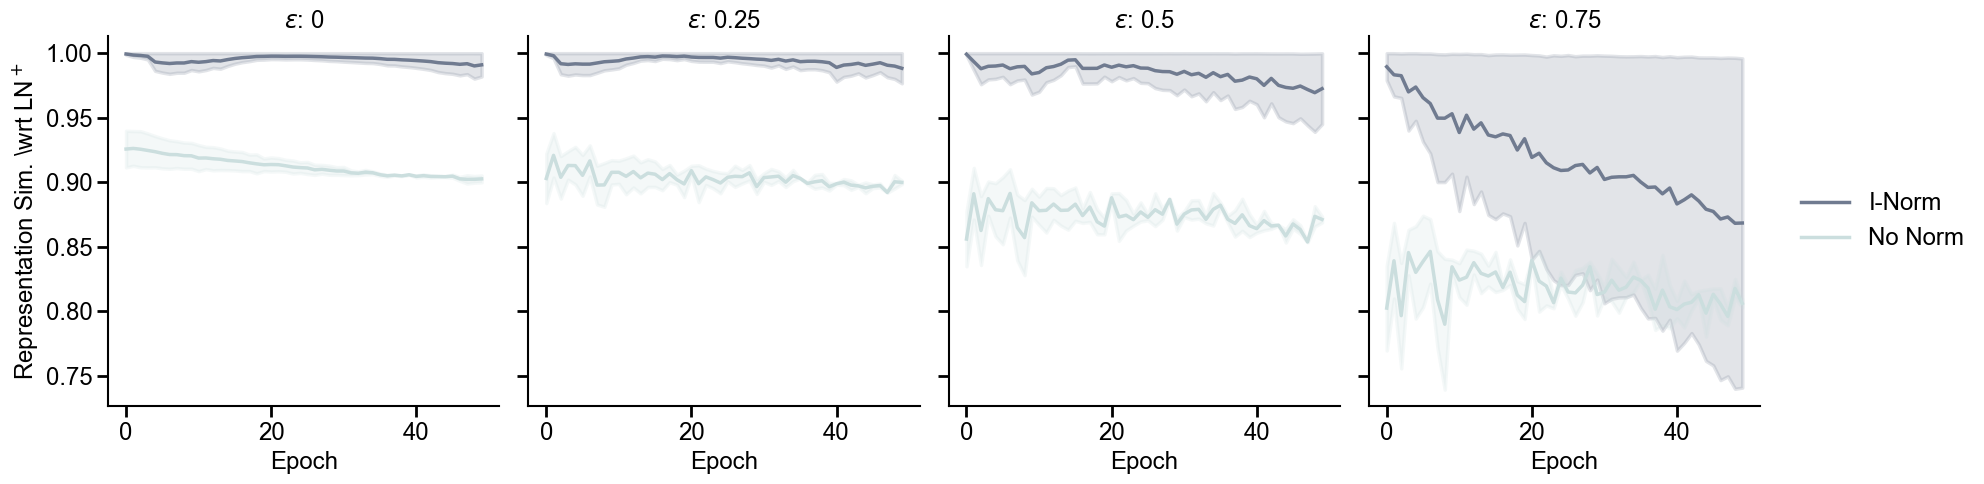

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm, colors

# Truncate bone colormap to avoid white
def truncate_colormap(cmap, minval=0.0, maxval=0.85, n=100):
    return colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup
brightness_factors = [0, 0.25, 0.5, 0.75]
ln_feedback_types = ['Homeostasis', 'No Homeostasis']
layers_to_average = ["fc0", "fc1"]

# Colors
trunc_bone = truncate_colormap(cm.get_cmap('bone'), 0.5, 0.85)
colors_bone = [trunc_bone(i / (len(ln_feedback_types) - 1)) for i in range(len(ln_feedback_types))]

# Create 1x4 subplot grid (one row, four columns)
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
axs = axs.flatten()

# Loop over brightness factors (each gets its own subplot)
for b_idx, bright in enumerate(brightness_factors):
    ax = axs[b_idx]

    for f_idx, ln_fdb in enumerate(ln_feedback_types):
        all_layer_data = []

        for layer in layers_to_average:
            # Fetch runs for this brightness and feedback type
            runs = fetch_runs(
                api,
                entity='project_danns',
                project_name='Luminosity_LNHomeostasis',
                filters={
                    "config.dataset": "fashionmnist",
                    "config.brightness_factor": bright,
                    "config.homeostasis": 1 if ln_fdb == 'Homeostasis' else 0,
                    "config.normtype": 0,
                    "config.normtype_detach": 1,
                    "config.excitation_training": 1 if ln_fdb == 'Homeostasis' else 0,
                    "config.layer_norm": None if ln_fdb == 'Homeostasis' else 0,
                    "config.use_testset": True,
                    "config.ln_feedback": 'center' if ln_fdb == 'Homeostasis' else None,
                },
                order="-summary_metrics.test_acc"
            )

            layer_histories = []

            for run in runs:
                hist = run.history(samples=5000000, keys=[f"output_alignment_{layer}"])
                if f"output_alignment_{layer}" in hist:
                    values = hist[f"output_alignment_{layer}"].astype(float).values
                    if not np.any(np.isnan(values)):
                        layer_histories.append(values)

            if layer_histories:
                # Truncate all histories to the shortest one
                min_len = min(len(arr) for arr in layer_histories)
                print(f'{ln_fdb} - {bright} - {layer} - {min_len}')
                truncated = [arr[:min_len] for arr in layer_histories]
                stacked = np.stack(truncated)
                all_layer_data.append(stacked)

        # Average across fc0 and fc1
        if all_layer_data:
            all_layer_data = np.stack(all_layer_data)  # shape: [2, num_runs, T]
            mean_per_layer = np.mean(all_layer_data, axis=1)  # shape: [2, T]
            avg_across_layers = np.mean(mean_per_layer, axis=0)
            std_across_layers = np.std(mean_per_layer, axis=0)

            ax.plot(
                avg_across_layers,
                label='I-Norm' if ln_fdb == 'Homeostasis' else 'No Norm',
                color=colors_bone[f_idx]
            )
            ax.fill_between(
                range(len(avg_across_layers)),
                avg_across_layers - std_across_layers,
                avg_across_layers + std_across_layers,
                alpha=0.2,
                color=colors_bone[f_idx]
            )

    ax.set_title(f"$\epsilon$: {bright}")
    ax.set_xlabel("Epoch")
    if b_idx == 0:
        ax.set_ylabel("Representation Sim. \wrt LN$^+$")
    ax.yaxis.set_major_formatter(ScalarFormatter())

# Legend outside the last subplot (on the right)
axs[-1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)

plt.tight_layout()
plt.savefig("figure2c.svg", format="svg")


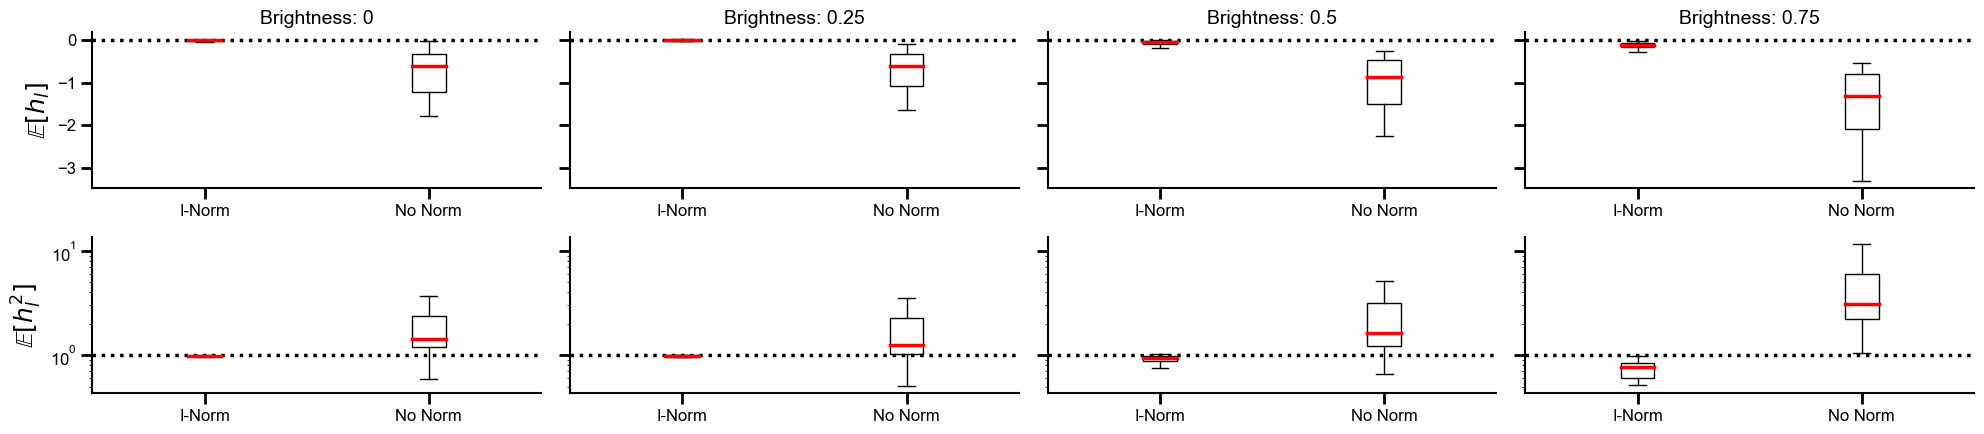

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.constrained_layout.use'] = False

brightness_factors = [0, 0.25, 0.5, 0.75]
ln_feedback_types = ['I-Norm', 'No Norm']

# Setup figure: 2 rows (mean & variance), 4 columns (brightness levels)
fig, axs = plt.subplots(2, 4, figsize=(20, 4.5), sharey='row')
fig.subplots_adjust(wspace=0.3, hspace=0.35)

for col, bright in enumerate(brightness_factors):
    mu_data = []
    var_data = []

    for ln_fdb in ln_feedback_types:
        # Fetch runs for this brightness and feedback type
        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bright,
                "config.homeostasis": 1 if ln_fdb == 'I-Norm' else 0,
                "config.normtype": 0,
                "config.normtype_detach": 1,
                "config.excitation_training": 1 if ln_fdb == 'I-Norm' else 0,
                "config.layer_norm": None if ln_fdb == 'I-Norm' else 0,
                "config.use_testset": True
            },
            order="-summary_metrics.test_acc"
        )

        mu_vals = []
        var_vals = []

        for run in runs:
            try:
                # Convert to float, skip if missing
                mu0 = float(run.summary.get("train_fc0_mu", np.nan))
                mu1 = float(run.summary.get("train_fc1_mu", np.nan))
                var0 = float(run.summary.get("train_fc0_var", np.nan))
                var1 = float(run.summary.get("train_fc1_var", np.nan))
            except (TypeError, ValueError):
                continue  # Skip if not convertible to float

            # Skip if any NaN
            if np.isnan(mu0) or np.isnan(mu1) or np.isnan(var0) or np.isnan(var1):
                continue

            # Average across fc0 and fc1
            mu_vals.append((mu0 + mu1) / 2)
            var_vals.append((var0 + var1) / 2)

        mu_data.append(mu_vals)
        var_data.append(var_vals)

    # Convert to object arrays (to handle uneven lengths)
    mu_data = np.array(mu_data, dtype=object)
    var_data = np.array(var_data, dtype=object)

    # --- Plot mean ---
    axs[0, col].boxplot(
        mu_data.T,
        patch_artist=True,
        boxprops=dict(color='black', facecolor='none'),
        medianprops=dict(linewidth=2.5, color='red'),
        showfliers=False
    )
    axs[0, col].set_title(f'Brightness: {bright}', fontsize=14)
    axs[0, col].set_xticks([1, 2])
    axs[0, col].set_xticklabels(ln_feedback_types, fontsize=12)
    axs[0, col].axhline(y=0, color='black', linestyle='dotted')
    axs[0, col].tick_params(axis='y', labelsize=12)
    # axs[0, col].set_yscale("log")
    if col == 0:
        axs[0, col].set_ylabel(r'$\mathbb{E}[h_l]$', fontsize=18)

    # --- Plot variance ---
    axs[1, col].boxplot(
        var_data.T,
        patch_artist=True,
        boxprops=dict(color='black', facecolor='none'),
        medianprops=dict(linewidth=2.5, color='red'),
        showfliers=False
    )
    axs[1, col].set_xticks([1, 2])
    axs[1, col].set_xticklabels(ln_feedback_types, fontsize=12)
    axs[1, col].axhline(y=1, color='black', linestyle='dotted')
    axs[1, col].tick_params(axis='y', labelsize=12)
    axs[1, col].set_yscale("log")
    if col == 0:
        axs[1, col].set_ylabel(r'$\mathbb{E}[h^2_l]$', fontsize=18)

plt.savefig("figure2c.svg", format="svg")


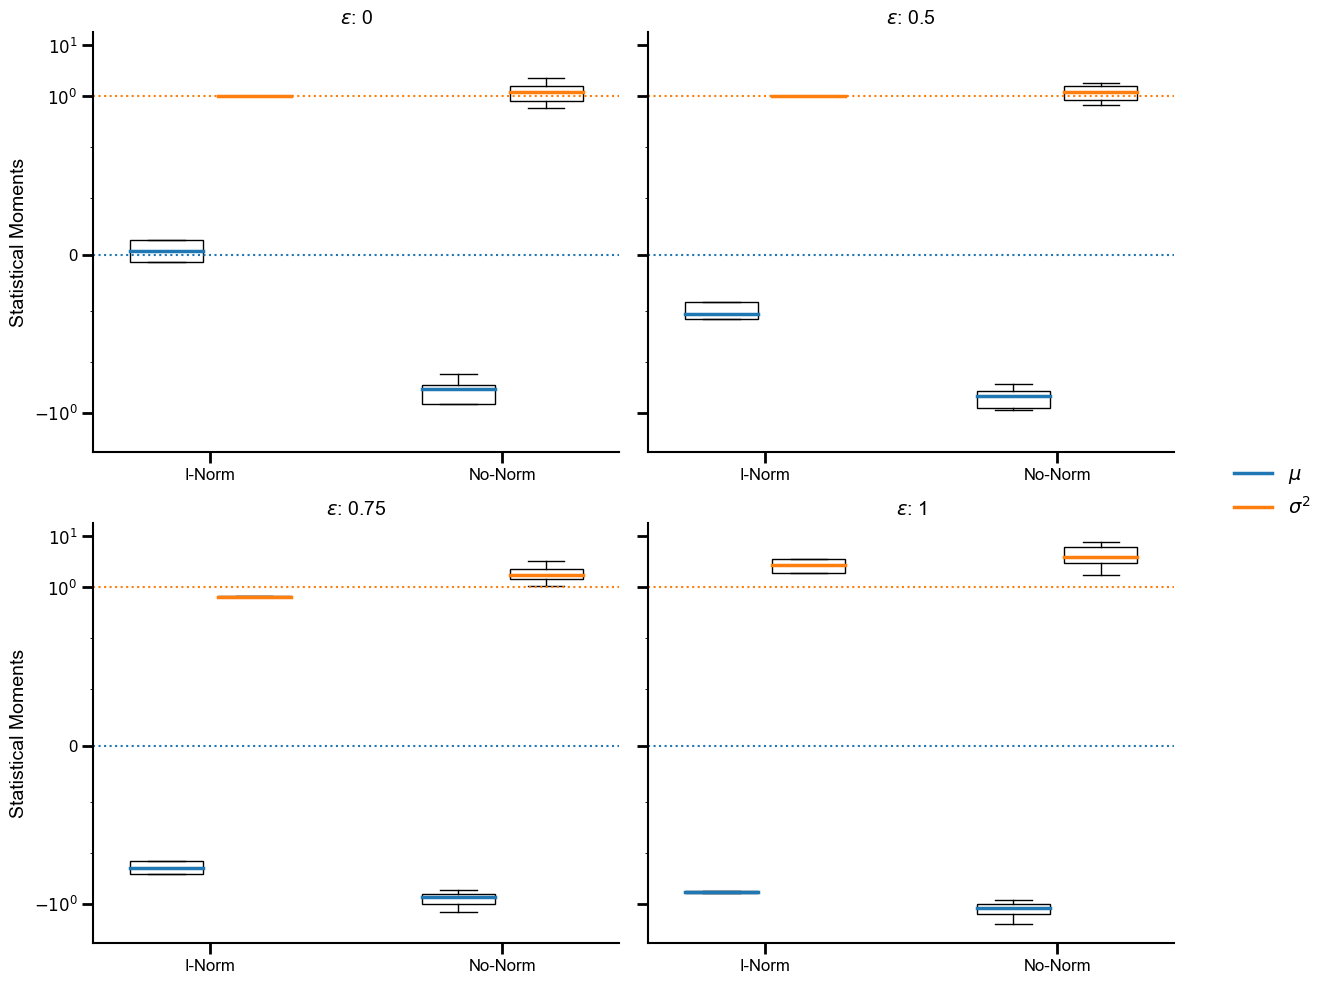

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.constrained_layout.use'] = False

brightness_factors = [0, 0.5, 0.75, 1]
ln_feedback_types = ['I-Norm', 'No-Norm']

mean_color = "tab:blue"
var_color = "tab:orange"

# 2x2 grid instead of 1x4
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()  # Flatten for easy indexing
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for col, bright in enumerate(brightness_factors):
    mu_data = []
    var_data = []

    for ln_fdb in ln_feedback_types:
        runs = fetch_runs(
            api,
            entity='project_danns',
            project_name='Luminosity_LNHomeostasis',
            filters={
                "config.dataset": "fashionmnist",
                "config.brightness_factor": bright,
                "config.homeostasis": 1 if ln_fdb == 'I-Norm' else 0,
                "config.normtype": 0,
                "config.normtype_detach": 1,
                "config.excitation_training": 1 if ln_fdb == 'I-Norm' else 0,
                "config.layer_norm": None if ln_fdb == 'I-Norm' else 0,
                "config.use_testset": True
            },
            order="-summary_metrics.test_acc"
        )[:10]

        mu_vals, var_vals = [], []

        for run in runs:
            try:
                mu0 = float(run.summary.get("train_fc0_mu", np.nan))
                mu1 = float(run.summary.get("train_fc1_mu", np.nan))
                var0 = float(run.summary.get("train_fc0_var", np.nan))
                var1 = float(run.summary.get("train_fc1_var", np.nan))
            except (TypeError, ValueError):
                continue

            if np.isnan(mu0) or np.isnan(mu1) or np.isnan(var0) or np.isnan(var1):
                continue

            mu_vals.append((mu0 + mu1) / 2)
            var_vals.append((var0 + var1) / 2)

        mu_data.append(mu_vals)
        var_data.append(var_vals)

    mu_data = np.array(mu_data, dtype=object)
    var_data = np.array(var_data, dtype=object)

    ax = axs[col]

    # Positions for mean and variance boxplots
    positions_mean = np.arange(1, len(ln_feedback_types)*2, 2)  # 1, 3
    positions_var = positions_mean + 0.6                        # 1.6, 3.6

    # Mean
    ax.boxplot(
        mu_data.T, positions=positions_mean, widths=0.5,
        patch_artist=True,
        boxprops=dict(color='black', facecolor='none'),
        medianprops=dict(linewidth=2.5, color=mean_color),
        showfliers=False
    )
    # Variance
    ax.boxplot(
        var_data.T, positions=positions_var, widths=0.5,
        patch_artist=True,
        boxprops=dict(color='black', facecolor='none'),
        medianprops=dict(linewidth=2.5, color=var_color),
        showfliers=False
    )

    ax.set_title(f'$\epsilon$: {bright}', fontsize=14)
    ax.set_xticks(positions_mean + 0.3)
    ax.set_xticklabels(ln_feedback_types, fontsize=12)

    # Reference lines
    ax.axhline(y=0, color=mean_color, linestyle='dotted', linewidth=1.5)
    ax.axhline(y=1, color=var_color, linestyle='dotted', linewidth=1.5)

    # Symmetric log scale
    ax.set_yscale("symlog", linthresh=1e-2)
    ax.tick_params(axis='y', labelsize=12)

    if col % 2 == 0:  # Left column gets y-label
        ax.set_ylabel(r'Statistical Moments', fontsize=14)

    ax.set_yticks([-1, 0, 1, 10])
    ax.set_yticklabels([r"$-10^0$", "0", r"$10^0$", r"$10^1$"])

fig.legend(
    [plt.Line2D([0], [0], color=mean_color, lw=2.5),
     plt.Line2D([0], [0], color=var_color, lw=2.5)],
    [r'$\mu$', r'$\sigma^2$'],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    frameon=False
)

plt.savefig("figure2b.svg", format="svg")
